# Tutorial 1. Extraction of a drainage network

In this tutorial we will extract a drainage network from a raster by using the three basic topopy objects: 
- **DEM** : Class to manipulate raster Digital Elevation Model
- **Flow**: Class to set up the flux (giver-receivers) between the cells of a DEM
- **Network**: Class to define channels cells and analyze morphometric features 

To run this tutorial in Jupyter, make sure that the "data" folder is inside the same folder of the notebook with the tutorial data. 

## 1. Create a DEM object from a raster

DEM class is one of the base clases of topopy. It allows to manipulate Digital Elevation Models in raster format. It also allows to fill pits in the model and display it using matplotlib. For this tutorial we will use a DEM in the data folder named "jebja30.tif". This 30m resolution DEM represents some coastal drainage basins in northern Morocco, being the main one the basin of Jebja river. 

To create and display a DEM in topopy simply execute:

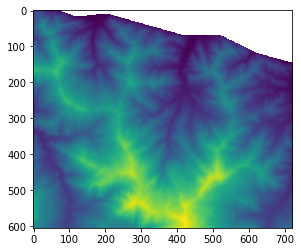

In [1]:
from topopy import DEM
dem = DEM("data/jebja30.tif")
dem.plot()

## 2. Create a Flow object from a DEM object

To extract a drainage network it is first necessary to create a Flow object. The Flow object topologically arranges all the cells of the DEM into two linear arrays: givers (cells that give flow) and receivers (cells that receive flow). The flow is directed entirely from one cell to any of its 8 neighboring cells following the D8 algorithm (steepest slope in the flow direction). This process is the slowest in the topopy library, and it is recommended to save the Flow object once created. 

To generate a Flow instance, the DEM is first filled.  If the DEM is already filled, pass `filled=True`. In flat areas it is possible to use an auxiliary topography from the unfilled DEM by setting `auxtopo=True`. However, the use of this auxiliary topography will slow down the process significantly (not recommended for large DEMs). To display messages showing progress set `verbose=True`.

The stream can be saved in a geotiff format using the `.save(path)` method. However, this is not a normal raster, and displaying it in GIS software will not make sense. 

In [2]:
# Create a Flow object from an unfilled DEM showing progress messages
from topopy import Flow
fd = Flow(dem, verbose=True)
fd.save("data/jebja30_fd.tif")

Flow algoritm started
Filling DEM ...
1/7 - DEM filled
Identifiying flats and sills ...
2/7 - Flats and sills identified
Identifiying presills ...
3/7 - Presills identified
Calculating weights ...
5/7 - Weights calculated
Sorting pixels ...
6/7 - Pixels sorted
Calculating receivers ...
7/7 - Receivers calculated
Finishing ...


## 3. Compute flow accumulation values and examine different flow thresholds.

To generate a drainage network it is necessary to set a flow threshold. Although not necessary, an intermediate step before creating the Network object could be to generate a Flow Accumulation raster. By displaying this raster in a GIS software it is possible to visualize different flow thresholds by changing its symbology.

To create and save a Flow Accumulation raster, we will use the method 
`.get_flow_accumulation()` . This method also allows to enter an accumulation raster (e.g. a precipitation raster to calculate the flow rate). 

In [3]:
fac = fd.get_flow_accumulation()
fac.save("data/jebja30_fac.tif")

# We can now check in QGIS (or other GIS software) the Flow Accumulation raster and try different thresholds

![image](images/flow_acc.jpg)

## 4. Extract drainage basins

It is possible to extract drainage basins from the Flow object by setting the XY coordinates of the desired pour points. If a point shapefile want to be used, it is possible to extract XY coordinates of it with the function `extract_points()` of topopy.

In the basin raster, each basin will be labeled by using an **id**. If the point shapefile contains a field with the *id* values simply pass this field when calling `extract_points()`function.

> - `extract_points(path, id_field=None)`.

To ensure that pour points (outlets) fall inside flow cells it is reccomendable to snap these points with the method `snap_points()` of the Flow object. If the points want to be snapped to a channel cell, it is necessary stablish a flow threshold.

> - `snap_points(input_points, threshold, kind="channel")`

To create and save drainage basins, we will use the method `.get_drainage_basins(outlets)`. The parameter outlet will be the snapped pour points.

For this tutorial, you can use the shapefile **_"jebja30_pour_points.shp"_** or create a point shapefile for yourself. The point shapefile contain 2 outlets labeled 1 and 2.

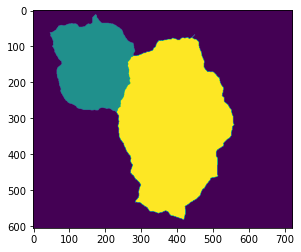

In [4]:
from topopy import extract_points

# Extract coordinates from the point shapefile
outlets = extract_points("data/jebja30_pour_points.shp", "id")
# Snap outlets to channels (1000 cells of flow threshold)
soutlets = fd.snap_points(outlets, threshold = 1000, kind = "channel")
# Create basins
basins = fd.get_drainage_basins(soutlets)
# Save basins (so they can be viewed with QGIS)
basins.save("data/basins.tif")
basins.plot()

## 5. Create a Network object

To create a Network object from a Flow object we will use the class Network. This class uses a flow threshold (**in number of cells**) to determine the Network. Only the givers and receivers from the Flow class within this threshold are used in this class. 

This class also contains data of elevation, drainage area, distance to outlet, and chi. Chi index is calculated by passing a m/n ratio as an argument (`thetaref`) when Network is created (default 0.45). It also allow to calculate gradients in each pixel: slope is calculated as the gradient in elevation-distance space, and ksn is calculated in elevation-chi space. 

Both, slope and ksn, are calculated in each pixel by linear regression using a number of cells up- and downstream. Residuals ($R^2$ determinants) for each pixel are also stored in the class. As the calculation of gradients can be time consuming, when a Network is created do not calculate gradients by default. If want to calculate when creating the Network, pass the argument `gradients=True`. To set up the analysis window (number of pixels up- and downstream) change the argument `npoints` (default 5). 

![image](images/slope_ksn.jpg)

Create a Network from a Flow object. 

>- `Network(flow=None, threshold=0, thetaref=0.45, npoints=5, gradients=False)`
    - `flow`: (topopy.Flow) Flow object
    - `threshold`: (int) Flow threshold (**number of cells**) to define a channel
    - `thetaref`: (float) Reference m/n to calculate Chi index
    - `npoints`: (int) Number of pixels up- and downstream to calculate gradients (slope and ksn)
    - `gradients`: (bool) Flag to set if gradients are calculated when creating the Network object

Load a previously save Network object.

>- `Network(path)`
    - `path` String with the path to a previously saved Network object.
    
Network objects can be saved with the method `.save(path)` and extensión *.dat

In [6]:
# Create a Network with a flow threshold of 1000 cells (0.45 square kilometers)
# Gradients will be not computed
# Chi index will be calculated with a m/n of 0.45
from topopy import Network
net = Network(fd, 1000, gradients=False)
net.save("data/jebja_net1000.dat")

Once the Network object is created and saved, it can be loaded by creating a new instance and passing the path as an argument. 
Regardless of the m/n value defined when creating the Network, it can be changed by calling the `.calculate_chi()` method. 

>- `Network.calulate_chi(thetaref=0.45, a0=1.0)`
    - `thetaref` (float) Reference m/n to calculate Chi index
    - `a0` (float) Reference area to avoid dimensionality (usually don't need to be changed)

If the gradients have not been calculated when creating the Network object, it is possible to calculate them independently by calling the `.calculate_gradients()` method
>- `Network.calulate_gradients(npoints, kind='slp')`
    - `npoints` (int) Number of pixels up- and downstream to calculate gradients
    - `kind` (str) {'slope', 'ksn'} Type of gradient to calculate

If the Chi and gradients are modified and the Network object is saved, the new values will be saved as well.


In [7]:
# Load a previously saved Network object. 
net = Network("out/jebja_net1000.dat")

# Re-calculate Chi index with a different m/n ratio
net.calculate_chi(0.3)

# Re-calculate slope with 5 points (up- and downstream)
net.calculate_gradients(5, "slp")

# Re-calculate ksn with 6 points (up- and downstream) [Using the new calculated chi values]
net.calculate_gradients(6, "ksn")

# Save the Network object with the new m/n ratio
net.save("out/jebja_net1000.dat")

FileNotFoundError: [Errno 2] No such file or directory: 'out/jebja_net1000.dat'

### 6. Get the drainage network in raster and vector formats

From a Network object it is possible to create a representation (raster or vector) of the drainage Network. The vector drainage Network can be set with continous channels or discrete channels. If continous channels option is selected, channels with the same order will be continuos lines, otherwise, channel will "break" at each confluence.

>- `Network.export_to_shp(con=False)`
    - `con` (boolean) Flag to indicate if continous channels are processed.

![image](images/con_channels.jpg)


In [9]:
# Create a vector drainage network with continous channels
net.export_to_shp("data/network_con.shp", con=True)

# Create a vector drainage network with non-continous channels
net.export_to_shp("data/network.shp", con=False)

To extract the drainage network in raster format, we can use the methods:

`.get_streams()`

`.get_stream_orders()`

Both methods give a **Grid** object as output that can be save in geotiff format to be viewed with QGIS. 

In [11]:
# Create a raster drainage network 
streams = net.get_streams()
streams.save("data/canales.tif")

# Create a raster drainage network ordered by strahler
streams = net.get_stream_orders()
streams.save("data/strahler.tif")